Main figure of the Alborex Data paper in ESSD journal.     
Only show the position of all the deployments (to keep things simple).

In [1]:
import os
import glob
import json
import logging
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
import datetime, time, calendar
import matplotlib.text as text
from matplotlib.path import Path
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import alborexdata
import alborex_functions
from importlib import reload

In [30]:
reload(alborexdata)

<module 'alborexdata' from '/home/ctroupin/Publis/201703_AlborexData/python/alborexdata.py'>

# Configuration
Most of the configuration (file paths, domain, resolution, ...) is done in the json file `alborexconfig.json`.

In [35]:
with open('alborexconfig.json') as json_data_file:
    config = json.load(json_data_file)
config

{'datadirs': {'adcp': '/home/ctroupin/Data/Alborex/ADCP/',
  'drifters': '/home/ctroupin/Data/Alborex/Drifters',
  'profilers': '/home/ctroupin/Data/Alborex/Profilers',
  'sst': '/home/ctroupin/Data/Alborex/SST/'},
 'datafiles': {'altimetry': '/home/ctroupin/DataOceano/AVISO/MedSea/Aviso_gridded/Alborex/dt_med_allsat_madt_uv_20140523_20141010.nc',
  'coast': '/home/ctroupin/Data/Alborex/Coastline/coastline_f.dat',
  'ctd': '/home/ctroupin/Data/Alborex/CTD/dep0007_socib-rv_scb-sbe9002_L1_2014-05-25.nc',
  'ctdlegs': ['/home/ctroupin/Data/Alborex/CTD/ctd_positions_Leg1.txt',
   '/home/ctroupin/Data/Alborex/CTD/ctd_positions_Leg2.txt'],
  'gliders': ['/home/ctroupin/Data/Alborex/Gliders/dep0005_icoast00_ime-slcost000_L1_2014-05-25_data_dt.nc',
   '/home/ctroupin/Data/Alborex/Gliders/dep0012_ideep00_ime-sldeep000_L1_2014-05-25_data_dt.nc'],
  'rv': '/home/ctroupin/Data/Alborex/RV/dep0015_socib-rv_scb-pos001_L1_2014-05-25.nc'},
 'domain': {'coordinates1': [-6.75, 3.001, 34.75, 40.0],
  'coo

## Flags for the plot

In [3]:
doplotsst, doplotvectors, doplotstream, doplotdrifters, doplotinset = 0, 0, 0, 1, 1

## Logger

In [4]:
logger = alborexdata.configure_logging()
logger.setLevel(logging.DEBUG)
logging.info("Starting")

## Time interval for the drifters

In [6]:
tt = datetime.datetime(2014, 5, 25, 0, 0, 0)
tt_end = datetime.datetime(2014, 6, 4, 0, 0, 0)
time_min = int(tt.strftime('%s'))
time_max = int(tt_end.strftime('%s'))
time_init = '2014-05-25T000000'
time_end = '2014-05-26T000000'

## Colormap and other things related to pcolor

In [8]:
cmapsst = plt.cm.RdYlBu_r
# Min and max values
sstmin, sstmax = 16., 21.
normsst = colors.Normalize(vmin=sstmin, vmax=sstmax)
boundsst = np.arange(sstmin, sstmax + .001, 1.0)

# Load data

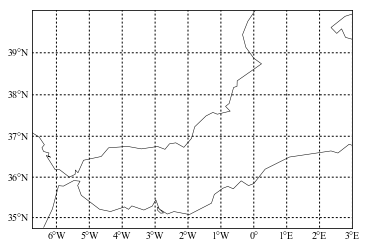

In [16]:
coordinates = config["domain"]["coordinates1"]
dlon, dlat = config["domain"]["resolution1"]

fig, m, ax = alborexdata.prepare_map(coordinates, res='l')
alborexdata.add_map_grid(m, coordinates, dlon, dlat)
m.drawcoastlines(linewidth=0.5)
plt.show()
plt.close()

## Load coast

In [22]:
coastfile = config["datafiles"]["coast"]
loncoast, latcoast = alborexdata.read_lonlat_coast(coastfile)

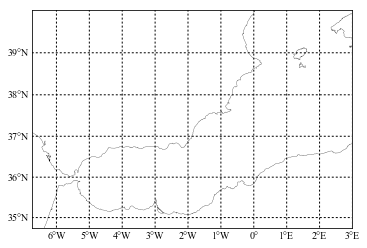

In [31]:
fig, m, ax = alborex_functions.prepare_map(coordinates, res='l')
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), color='k', linewidth=.25, latlon=True)
alborexdata.add_map_grid(m, coordinates, dlon, dlat)
plt.show()
plt.close()

## CTD

In [33]:
ctd = alborexdata.CTD()
ctd.get_from_netcdf(config["datafiles"]["ctd"])
lonCTD1, latCTD1 = alborexdata.load_lonloat_ctdleg(config["datafiles"]["ctdlegs"][0])

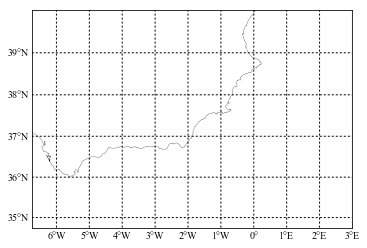

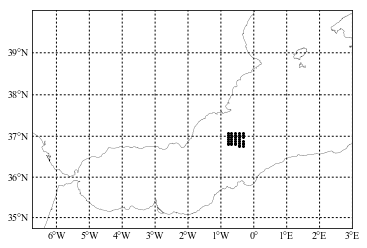

In [34]:
fig, m, ax = alborex_functions.prepare_map(coordinates, res='l')
alborexdata.add_map_grid(m, coordinates, dlon, dlat)
for i in range(0, len(loncoast)):
    m.plot(np.array(loncoast[i]), np.array(latcoast[i]), 
           color='k', linewidth=.25, latlon=True)
    m.plot(lonCTD1, latCTD1, 'ko', ms=1, latlon=True)
plt.show()
plt.close()

## Gliders

In [36]:
glider1 = alborexdata.Glider()
glider1.get_from_netcdf(config["datafiles"]["gliders"][0])
glider2 = alborexdata.Glider()
glider2.get_from_netcdf(config["datafiles"]["gliders"][1])

## Drifters

In [43]:
drifterlist = sorted(glob.glob(os.path.join(config["datadirs"]["drifters"], "*nc")))

In [39]:
fig, m, ax = alborexdata.prepare_map(coordinates, "l")

m.drawmapscale(-0.45, 35.1, -0.25, 35.1, 100, barstyle='simple', units='km', fontsize=12, zorder=3)

# Labels
xtext, ytext = m(coordinates[1] - .1, coordinates[2] + .25)
#  plt.text(xtext, ytext, "AFRICA", va='center', ha='right',
# fontsize=18, bbox=dict(fc='w', ec="w", lw=0.5,alpha=0.8, pad=5.0))

xa1, ya1 = m(-2.5, 37.7)
ax.annotate("SPAIN", xy=(xa1,ya1), xytext=(xa1,ya1),
            xycoords='data', textcoords='data', fontsize=16
            )

xa1, ya1 = m(-6, 34.8)
xa2, ya2 = m(-6, 34.8)
ax.annotate("AFRICA", xy=(xa1,ya1), xytext=(xa2,ya2),
            xycoords='data', textcoords='data', fontsize=16
            )

xa1, ya1 = m(-3, 35.7)
xa2, ya2 = m(-3, 35.7)
ax.annotate("Alboran Sea", xy=(xa1,ya1), xytext=(xa2,ya2),
            xycoords='data', textcoords='data', fontsize=16,
            zorder=7
            )

# Add drifter trajectories on map
# -------------------------------
if doplotdrifters:

    londriftertotal, latdriftertotal, ndrifters = 0, 0, 0

    for drifter in drifterlist:
        with netcdf.Dataset(drifter_opendap) as nc:
                timedrifter = nc.variables['time'][:]
                goodtime = np.where((timedrifter > time_min) & (timedrifter < time_max))[0]
                londrifter = nc.variables['LON'][goodtime]
                latdrifter = nc.variables['LAT'][goodtime]
                londrifter, latdrifter = m(londrifter, latdrifter)
                m.plot(londrifter, latdrifter, 'ko', ms=0.1, alpha=.85, zorder=5)
                londriftertotal += londrifter[0]
                latdriftertotal += latdrifter[0]
                ndrifters += 1
    add_logo_on_map(driferlogo, ax, [londriftertotal / ndrifters, latdriftertotal / ndrifters], 0.1, zorder=6)

logger.info("Add rectangle for experiment")
patch = create_rect_patch(coordinates2, m, 0.1)
ax.add_patch(patch)
# and for Gibraltar
# patch = create_rect_patch(coordinates3, m, 0.2)
# ax.add_patch(patch)

# CTD and gliders
# m.plot(lonCTD,latCTD,'ko',ms=1, zorder=6)

# Coastline and continent
m.plot(loncoast2, latcoast2, 'k-', lw=0.1, zorder=4)
m.fillcontinents(ax=ax, color='0.9', zorder=2)

# plt.title(r"25$-$31 May, 2014", fontsize=20)

# Plot inset with CTD and gliders
if doplotinset:
    axins = zoomed_inset_axes(ax, 4.5, loc=2)
    n1, n2 = m(coordinates2[0], coordinates2[2])
    n3, n4 = m(coordinates2[1], coordinates2[3])
    axins.set_xlim(n1, n3)
    axins.set_ylim(n2, n4)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

    # Add gliders tracks and CTD casts
    NN = 34

    axins.plot(lonCTD[:NN], latCTD[:NN], 'ks-', lw=0.5, color=".75", ms=5, zorder=2,
               label=r"CTD 1st leg ($\times$ 34)", alpha=.7)
    axins.plot(lonCTD[NN:], latCTD[NN:], 'kx-', lw=0.2, ms=2.5, zorder=2, label=r"CTD 2nd leg ($\times$ 28)",
               alpha=.7)

    axins.plot(longlider1, latglider1, '-', lw=3, color='k', label="Deep glider", zorder=3)
    axins.plot(longlider1, latglider1, '--', lw=3, color='.75', zorder=3)

    axins.plot(longlider2, latglider2, '-', lw=1.5, color='k', label="Coastal glider", zorder=4)
    axins.plot(longlider2, latglider2, '--', lw=1.5, color='.75', zorder=4)

    if doplotdrifters:
        axins.plot(londriftertotal / ndrifters, latdriftertotal / ndrifters, 'ko', ms=0.1,
                   label=r"Drifters ($\times$ 25)")
    if doplotsst:
        axins.pcolormesh(x, y, sst, cmap=cmapsst, norm=normsst, edgecolor='none')

    axins.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)

    add_logo_on_map(gliderlogo, axins, [longlider1[0], latglider1[0]], 0.1, zorder=6)
    add_logo_on_map(gliderlogo, axins, [longlider2[0], latglider2[0]], 0.1, zorder=6)

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

"""
plt.savefig(os.path.join(figdir, figname), dpi=300, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.savefig(os.path.join(figdir, figname + '.eps'), dpi=300, facecolor='w', edgecolor='w',
            transparent=False, bbox_inches='tight', pad_inches=0.1)
"""
plt.show()
plt.close()

AttributeError: 'str' object has no attribute 'product_list'